# GKR protocol

**This notebook is under construction**

<a id='contents'></a>
## Contents

* [Setup](#setup)
* [Introduction](#introduction)
* [Worked Example](#worked_example)
* [The GKR protocol (formal description)](#formal_description)
* [...](#...)
* [...](#...)
* [References](#references)

<a id='setup'></a>
## Setup
↑↑ [Contents](#contents) ↓ [Introduction](#introduction)

In [1]:
import gkr
env = gkr.init(verbose=False)

<a id='introduction'></a>
## Introduction
↑↑ [Contents](#contents) ↑ [Setup](#setup) ↓ [Worked Example](#worked_example)

Building on our exploration of the [sum-check protocol](./01-sum-check-protocol), [multilinear extensions](./02-multilinear-extensions), and [arithmetic circuits](./03-arithmetic-circuits), we are now ready to present the GKR protocol in full. Originally introduced by Goldwasser, Kalai, and Rothblum [[GKR2008]](#gkr2008), and refined by many authors since, GKR is a cornerstone of modern interactive proofs for verifying circuit computations. This notebook assembles the objects and identities from the previous notebooks and shows how they combine into the protocol itself. We follow Thaler's presentation [[THA2022](#tha2022), §4.6].

<a id='worked_example'></a>
## Worked Example
↑↑ [Contents](#contents) ↑ [Introduction](#introduction) ↓ [...](#...)

We proceed via a complete worked example. It serves two purposes: (i) to summarize the key objects (multilinear extensions, wiring predicates, Thaler's identity), and (ii) to illustrate the recurring GKR pattern: **run sum-check on Thaler's identity**, then apply a **folding** step that converts a claim about two values into a single claim at a fresh random point.

No example small enough to compute fully by hand can showcase GKR's asymptotic savings: our toy computation is trivial, while the protocol machinery is comparatively elaborate. The value of the example is conceptual. Later we will discuss complexity and explain why, for large circuits, the verifier's work in GKR is asymptotically far smaller than re-evaluating the circuit.

**Example 1 [setup and arithmetic circuit].** Work over the field $\mathbb{F} = \mathbb{Z}/p\mathbb{Z}$, where $p = 2^{31} - 1$ is the eighth Mersenne prime. Consider the $4$-variate polynomial
\begin{equation*}
P \in \mathbb{F}[X_0,X_1,X_2,X_3], \quad P(X_0,X_1,X_2,X_3) := X_0X_1 + X_2 + X_3.
\end{equation*}
For instance,
\begin{equation*}
P(3,2,4,1) \equiv (3\cdot 2) + (4 + 1) \equiv 11 \bmod p.
\end{equation*}

We represent this computation by a **constant-input, binary, strictly layered** arithmetic circuit $C$ of size $7$ and depth $d = 2$:

- Layer 2 (inputs): the four inputs $3,2,4,1$;
- Layer 1: one multiplication gate and one addition gate, computing $3\cdot 2 \equiv 6$ and $4 + 1 \equiv 5$;
- Layer 0 (output): one addition gate computing $6 + 5 \equiv 11$.

In this example, Layer i has size $S_i = 2^i$, hence bit-length $s_i = \lceil \log_2 S_i\rceil = i$ for $i \in \{0,1,2\}$. (For general circuits, $s_i$ need not equal $i$.)

We label the gates in Layer i using bitstrings of length $s_i$ as follows:

- Layer 2 (inputs): $3 \mapsto (0,0), \; 2 \mapsto (0,1), \; 4 \mapsto (1,0), \; 1 \mapsto (1,1)$.
- Layer 1: $\times \mapsto 0, \; + \mapsto 1$.
- Layer 0 (output): $+ \mapsto \emptyset$ (the empty bitstring, also written $()$).


EXAMPLE 1


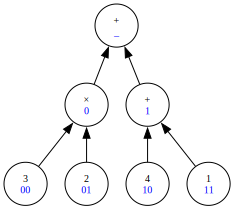

In [2]:
# NB: it may be necessary to restart the notebook and run this code cell again in order for the labeling below to match our written example.
from gkr.utils.display import print_header
from gkr.ac import ArithmeticCircuit

eg_count = 1

expression_01 = '(3*2) + (4 + 1)'
gkr_01 = ArithmeticCircuit(expression_01, prime=2**(31) - 1)

print_header(f"Example {eg_count}\n", level = 2)
display(gkr_01.graphviz_circuit_bitstring)

**Gate-value functions.** For each layer $i \in \{0,\ldots,d\}$, the **gate-value function**
\begin{equation*}
W_i : \{0,1\}^{s_i} \to \mathbb{F}
\end{equation*}
records the value at each gate. By multilinear interpolation on the Boolean hypercube, each $W_i$ has a unique **multilinear extension**
\begin{equation*}
\widetilde{W}_i : \mathbb{F}^{s_i} \to \mathbb{F}.
\end{equation*}

**Example 1 [gate-value functions].** In our example,
\begin{align*}
W_2(0,0) &= 3, & W_2(0,1) &= 2, & W_2(1,0) &= 4, & W_2(1,1) &= 1,\\
W_1(0) &= 6, & W_1(1) &= 5,\\
W_0(\emptyset) &= 11.
\end{align*}
These admit the multilinear extensions (computed explicitly below)
\begin{equation*}
\widetilde{W}_2(v_0,v_1) = -2v_0v_1 + v_0 - v_1 + 3,\qquad
\widetilde{W}_1(v) = 6 - v,\qquad
\widetilde{W}_0(\emptyset) = 11.
\end{equation*}
For instance,
\begin{equation*}
\widetilde{W}_2(1,1) = -2(1\cdot 1) + 1 - 1 + 3 \equiv 1 \bmod p,
\end{equation*}
matching $W_2(1,1)$. <span style="float:right">$\blacksquare$</span>

**Wiring predicates.** For $i \in \{0,\ldots,d-1\}$, define wiring predicates
\begin{equation*}
\mathrm{add}_i,\,\mathrm{mult}_i : \{0,1\}^{s_i} \times \{0,1\}^{s_{i+1}} \times \{0,1\}^{s_{i+1}} \to \{0,1\},
\end{equation*}
encoding the circuit topology. Concretely, $\mathrm{add}_i(\mathbf{c},\mathbf{a},\mathbf{b}) = 1$ iff $\mathbf{c}$ is an addition gate whose two children are $\mathbf{a}$ and $\mathbf{b}$, and $\mathbf{a} \le \mathbf{b}$ (lexicographic order). Similarly for $\mathrm{mult}_i$. Each wiring predicate has a unique multilinear extension
\begin{equation*}
\widetilde{\mathrm{add}}_i,\,\widetilde{\mathrm{mult}}_i : \mathbb{F}^{s_i} \times \mathbb{F}^{s_{i+1}} \times \mathbb{F}^{s_{i+1}} \to \mathbb{F}.
\end{equation*}

**Example 1 [wiring predicates].** In our circuit,
\begin{equation*}
\mathrm{add}_0(\emptyset,0,1) = 1,\quad
\mathrm{mult}_1(0,(0,0),(0,1)) = 1,\quad
\mathrm{add}_1(1,(1,0),(1,1)) = 1,
\end{equation*}
and all other values are zero. The multilinear extensions are:
\begin{align*}
\widetilde{\mathrm{add}}_0(\emptyset,x,y) &= (1-x)y,\\
\widetilde{\mathrm{mult}}_0(\emptyset,x,y) &= 0,\\
\widetilde{\mathrm{add}}_1(z,(x_0,x_1),(y_0,y_1)) &= zx_0(1-x_1)y_0y_1,\\
\widetilde{\mathrm{mult}}_1(z,(x_0,x_1),(y_0,y_1)) &= (1-z)(1-x_0)(1-x_1)(1-y_0)y_1.
\end{align*}
<span style="float:right">$\blacksquare$</span>

**Gate propagation and Thaler's identity.** The circuit semantics are captured by the **layer-wise gate propagation equation**: for $i \in \{0,\ldots,d-1\}$ and $\mathbf{z}\in\{0,1\}^{s_i}$,
\begin{equation}
W_i(\mathbf{z}) =
\sum_{\substack{\mathbf{x}\in\{0,1\}^{s_{i+1}}\\ \mathbf{y}\in\{0,1\}^{s_{i+1}}}}
\Big\{
\mathrm{add}_i(\mathbf{z},\mathbf{x},\mathbf{y})\big[W_{i+1}(\mathbf{x})+W_{i+1}(\mathbf{y})\big]
+
\mathrm{mult}_i(\mathbf{z},\mathbf{x},\mathbf{y})\big[W_{i+1}(\mathbf{x})W_{i+1}(\mathbf{y})\big]
\Big\}.
\tag{1}
\end{equation}
Thaler's identity is the multilinear-extension analogue: for $i \in \{0,\ldots,d-1\}$ and $\mathbf{z}\in\mathbb{F}^{s_i}$,
\begin{equation}
\widetilde{W}_i(\mathbf{z}) =
\sum_{\substack{\mathbf{x}\in\{0,1\}^{s_{i+1}}\\ \mathbf{y}\in\{0,1\}^{s_{i+1}}}}
\Big\{
\widetilde{\mathrm{add}}_i(\mathbf{z},\mathbf{x},\mathbf{y})\big[\widetilde{W}_{i+1}(\mathbf{x})+\widetilde{W}_{i+1}(\mathbf{y})\big]
+
\widetilde{\mathrm{mult}}_i(\mathbf{z},\mathbf{x},\mathbf{y})\big[\widetilde{W}_{i+1}(\mathbf{x})\widetilde{W}_{i+1}(\mathbf{y})\big]
\Big\}.
\tag{2}
\end{equation}

**Example 1 [layer-wise gate propagation and Thaler's identity].** In our example, $(2)$ expands to
\begin{equation}
11 = \sum_{x\in\{0,1\}} \sum_{y\in\{0,1\}} (1-x)y\big[(6-x)+(6-y)\big].
\tag{3}
\end{equation}
and
\begin{align}
6 - z
&= \sum_{x_0\in\{0,1\}}\sum_{x_1\in\{0,1\}}\sum_{y_0\in\{0,1\}}\sum_{y_1\in\{0,1\}}
\Big\{
zx_0(1-x_1)y_0y_1\big[(-2x_0x_1+x_0-x_1+3)+(-2y_0y_1+y_0-y_1+3)\big] \notag \\
&\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
+ \; (1-z)(1-x_0)(1-x_1)(1-y_0)y_1\big[(-2x_0x_1+x_0-x_1+3)(-2y_0y_1+y_0-y_1+3)\big]
\Big\}.
\tag{4}
\end{align}
<span style="float:right">$\blacksquare$</span>

**What is being verified?** The circuit $C$ (including its wiring predicates) is public. The prover's private information is the collection of intermediate gate values, equivalently the functions $W_i$. In the single-output setting, the prover's top-level claim is simply that the output gate evaluates to a particular field element (here, $11$).

More generally, Layer 0 may contain **multiple output gates**. We label the $S_0$ outputs by $\{0,1\}^{s_0}$, and the function
\begin{equation*}
W_0 : \{0,1\}^{s_0}\to\mathbb{F}
\end{equation*}
encodes all outputs at once. The prover's claim is that the true output function $W_0$ equals a purported function $W_0^*$ (equivalently, $\widetilde{W}_0=\widetilde{W}_0^*$ as polynomial functions).

The verifier does not check equality at all points. Instead, they sample a uniformly random $\rho_0\in\mathbb{F}^{s_0}$ and check equality at that point:
\begin{equation*}
\widetilde{W}_0(\rho_0) = \widetilde{W}_0^*(\rho_0).
\end{equation*}
If $\widetilde{W}_0\neq \widetilde{W}_0^*$, then $\widetilde{W}_0-\widetilde{W}_0^*$ is a nonzero multilinear polynomial function (degree $\le s_0$), so by Schwartz-Zippel,
\begin{equation*}
\Pr\big[\widetilde{W}_0(\rho_0)=\widetilde{W}_0^*(\rho_0)\big]
= \Pr\big[(\widetilde{W}_0-\widetilde{W}_0^*)(\rho_0)=0\big]
\le \frac{s_0}{\#\mathbb{F}}.
\end{equation*}
Thus, a match at a random point gives strong evidence that all output gates are correct.

**From Thaler's identity to GKR.** Fix a layer $i$. The verifier does not try to check $(2)$ for all $\mathbf{z}\in\mathbb{F}^{s_i}$. Instead, they sample a random point $\rho_i\in\mathbb{F}^{s_i}$ and ask the prover to justify $(2)$ at $\mathbf{z}=\rho_i$.

Once $\rho_i$ is fixed, the right-hand side of $(2)$ becomes a polynomial function in the $2s_{i+1}$ Boolean variables $(\mathbf{x},\mathbf{y})$. The prover and verifier then run sum-check over these variables. At the end of sum-check, the verifier is left with a small number of claimed values of $\widetilde{W}_{i+1}$; the folding step compresses these into a **single** new claim about $\widetilde{W}_{i+1}$ at a fresh random point $\rho_{i+1}$.

As in the sum-check notebook, we distinguish circuit-determined objects from prover-asserted objects. We use $(\cdot)^*$ (e.g. $\widetilde{W}_i^*$) for prover claims, which may be false. For clarity, we sometimes use the notation $\;\overset{?}{=}\;$ for an equality that may not hold if P is dishonest. Unadorned symbols refer to the true objects induced by the circuit. For readability, we reuse symbols like the verifier challenges $r_j$ and the prover's round polynomials $g_j$ across different sum-check invocations; they are "reset" each time a new sum-check begins.

**GKR Layer 0.** The parties are the **verifier** V and the **prover** P. V samples $\rho_0 \leftarrow \mathbb{F}^{s_0}$. Define
\begin{equation}
g(\mathbf{x},\mathbf{y}) :=
\widetilde{\mathrm{add}}_0(\rho_0,\mathbf{x},\mathbf{y})\big[\widetilde{W}_{1}(\mathbf{x})+\widetilde{W}_{1}(\mathbf{y})\big]
+
\widetilde{\mathrm{mult}}_0(\rho_0,\mathbf{x},\mathbf{y})\big[\widetilde{W}_{1}(\mathbf{x})\widetilde{W}_{1}(\mathbf{y})\big],
\tag{5}
\end{equation}
the summand in $(2)$ when $i=0$ and $\mathbf{z}=\rho_0$. Thus,
\begin{equation}
\widetilde{W}_0(\rho_0)
=
\sum_{(\mathbf{x},\mathbf{y})\in \{0,1\}^{s_1}\times \{0,1\}^{s_1}}
g(\mathbf{x},\mathbf{y}).
\tag{6}
\end{equation}
Moreover $\deg g \le 4s_1$: the wiring polynomials have degree $\le 2s_1$, the multilinear extensions $\widetilde{W}_1(\mathbf{x})$ and $\widetilde{W}_1(\mathbf{y})$ have degree $\le s_1$, and the worst case comes from the product term. (In general Layer $i$, the same reasoning gives $\deg g \le 4s_{i+1}$.)

The protocol runs sum-check on $(6)$ (with the prover's possibly false claim for $\widetilde{W}_0(\rho_0)$ on the left-hand side), with one crucial twist at the final step: instead of having V evaluate $g(r_x,r_y)$ directly, GKR uses claimed values of $\widetilde{W}_1$ and then folds them into a single new claim.

**Example 1 [GKR Layer 0].** Here $s_0=0$, so $\mathbb{F}^{s_0}=\{\emptyset\}$ and $\rho_0=\emptyset$. Also $s_1=1$, and from $(3)$ we set
\begin{equation*}
g(x,y) := (1-x)y\big[(6-x)+(6-y)\big].
\end{equation*}

To see how cheating is forced to "thread the needle", suppose P falsely claims that $\widetilde{W}_0(\rho_0)$ equals $10$ (the truth is $11$). The sum-check claim is
\begin{equation*}
\widetilde{W}_0^*(\rho_0) \overset{?}{=} \sum_{x,y\in\{0,1\}} g(x,y),
\end{equation*}
which is true iff the left-hand side equals $11$. Since P insists on $\widetilde{W}_0^*(\rho_0) = 10$, they must lie consistently, and later they will still need luck to avoid detection.

**Sum-check Round 0.0.** Define
\begin{equation*}
g_0(u_0) := \sum_{y\in\{0,1\}} g(u_0,y) = g(u_0,0)+g(u_0,1),
\end{equation*}
so that, as $\widetilde{W}_0$ and $g_0$ are ground-truth polynomial functions, $\widetilde{W}_0(\rho_0)=g_0(0)+g_0(1)$. P sends $g_0^*$, and V checks:
1. $\deg g_0^* \le 4s_1 = 4$,
2. $\widetilde{W}_0^*(\rho_0)=g_0^*(0)+g_0^*(1)$.

If both pass, V samples $r_0\leftarrow\mathbb{F}$ and sends it to P.

In truth, $g_0(u_0)=(1-u_0)(11-u_0)$, but V does not know this. To satisfy the checks while forcing $g_0^*(0)+g_0^*(1)=10$, P can pick (for example)
\begin{equation*}
g_0^*(u_0) := 2u_0(u_0-7)+11,
\end{equation*}
since
\begin{equation*}
g_0^*(0)+g_0^*(1) = 11 + \big(2(-6)+11\big)=10=\widetilde{W}_0^*(\emptyset).
\end{equation*}
Suppose V chooses $r_0=17$.

**Sum-check Round 0.1.** Define $g_1(u_1):=g(r_0,u_1)$, so $g_0(r_0)=g_1(0)+g_1(1)$. P sends $g_1^*$, and V checks:
1. $\deg g_1^* \le 4$,
2. $g_0^*(r_0)=g_1^*(0)+g_1^*(1)$.

If both pass, V samples $r_1\leftarrow\mathbb{F}$ and sends it to P.

Since $r_0=17$, the truth is
\begin{equation*}
g_1(u_1)=g(17,u_1)=(1-17)u_1\big[6-17+6-u_1\big]=16u_1(5+u_1),
\end{equation*}
but P can instead claim
\begin{equation*}
g_1^*(u_1):=u_1(17u_1+334),
\end{equation*}
which satisfies
\begin{equation*}
g_1^*(0)+g_1^*(1)=351=2\cdot 17(17-7)+11=g_0^*(17).
\end{equation*}
Suppose V chooses $r_1=42$.

**Sum-check final check (where GKR diverges).** In standalone sum-check, V would check $g_1^*(r_1)\overset{?}{=}g(r_0,r_1)$, but in GKR V does not directly evaluate $g(r_0,r_1)$.

Instead, define
\begin{equation*}
z_0 := \widetilde{W}_1(r_0),\qquad z_1 := \widetilde{W}_1(r_1),
\end{equation*}
and P supplies claimed values $z_0^*,z_1^*$ asserted to equal $z_0,z_1$.

In our example, the ground truth is
\begin{equation*}
z_0 = \widetilde{W}_1(17)=6-17=-11,\qquad
z_1 = \widetilde{W}_1(42)=6-42=-36,
\end{equation*}
and also
\begin{equation*}
g(r_0,r_1)=g(17,42)=16\cdot 42(5+42)=1974,
\end{equation*}
whereas
\begin{equation*}
g_1^*(r_1)=g_1^*(42)=42(17\cdot 42+334)=44016,
\end{equation*}
so standalone sum-check would reject. GKR postpones this evaluation and moves to folding. <span style="float:right">$\blacksquare$</span>

At this point, V has reduced a claim about $\widetilde{W}_0$ to two claimed values of $\widetilde{W}_1$. Recursing naïvely would cause a blow-up. Folding avoids this by compressing two claims into one.

**GKR folding at Layer 0.** At the end of the Layer 0 sum-check, V is left to verify
\begin{equation}
g_{2s_1-1}^*(r_{2s_1-1}) \overset{?}{=} g(r_x,r_y),
\tag{7}
\end{equation}
where
\begin{equation*}
r_x=(r_0,\ldots,r_{s_1-1})\in\mathbb{F}^{s_1},\qquad
r_y=(r_{s_1},\ldots,r_{2s_1-1})\in\mathbb{F}^{s_1}
\end{equation*}
are the verifier challenge vectors from the $2s_1$ rounds. P supplies claimed values
\begin{equation}
\widetilde{W}_1(r_x)\overset{\mathsf{P}}{\underset{\text{claim}}{=}}z_0^*,\qquad \widetilde{W}_1(r_y)\overset{\mathsf{P}}{\underset{\text{claim}}{=}}z_1^*.
\tag{8}
\end{equation}
Together, $(5)$, $(7)$, and $(8)$ amount to the "bridging" equation
\begin{equation}
g_{2s_1-1}^*(r_{2s_1-1})
\overset{?}{=}
\widetilde{\mathrm{add}}_0(\rho_0,r_x,r_y)\big[z_0^*+z_1^*\big]
+
\widetilde{\mathrm{mult}}_0(\rho_0,r_x,r_y)\big[z_0^*z_1^*\big].
\tag{9}
\end{equation}
Since the circuit is public, V can evaluate $\widetilde{\mathrm{add}}_0$ and $\widetilde{\mathrm{mult}}_0$ at any point, so V checks $(9)$ and rejects if it fails.

Now fold the two claims in $(8)$ into a single claim. Define the affine line $\ell:\mathbb{F}\to\mathbb{F}^{s_1}$ by
\begin{equation}
\ell(t):=(1-t)r_x + t r_y,
\tag{10}
\end{equation}
and define the associated univariate polynomial function $q_1 : \mathbb{F} \to \mathbb{F}$ by
\begin{equation}
q_1(t):=\widetilde{W}_1(\ell(t)).
\tag{11}
\end{equation}
By construction, $q_1(0)=\widetilde{W}_1(r_x)$ and $q_1(1)=\widetilde{W}_1(r_y)$.

P sends a univariate polynomial function $q_1^*$, purported to equal $q_1$. V checks:
1. $\deg q_1^* \le s_1$,
2. $q_1^*(0)=z_0^*$ and $q_1^*(1)=z_1^*$.

If these checks pass, V samples $\tau_1\leftarrow\mathbb{F}$ and sets
\begin{equation}
\rho_1 := \ell(\tau_1)\in\mathbb{F}^{s_1}.
\tag{12}
\end{equation}
In an honest execution, $q^*_1$ is the true $q_1$, and hence $q_1^*(\tau_1)$ is equal to $\widetilde{W}_1(\rho_1)$. Thus the two claims in $(8)$ have been reduced to a single claim about $\widetilde{W}_1$ at the random point $\rho_1$. The protocol then proceeds to Layer $1$.

**Example 1 [GKR folding at Layer 0].** In this example, $r_x=r_0$ and $r_y=r_1$. P supplies $z_0^*,z_1^*$, and V checks
\begin{equation}
g_1^*(r_1) \overset{?}{=} (1-r_0)r_1\big[z_0^*+z_1^*\big].
\tag{13}
\end{equation}
Define $\ell$ as in $(10)$ and $q_1$ as in $(11)$. Here $\ell(t)=(1-t)r_0+tr_1$ and $q_1(t)=\widetilde{W}_1(\ell(t))=6-\ell(t)$. P sends $q_1^*$ and V checks the endpoint constraints (and $\deg q_1^*\le 1$). Then V samples $\tau_1\leftarrow\mathbb{F}$ and defines $\rho_1=\ell(\tau_1)$ as in $(12)$. In an honest execution, $q_1^*(\tau_1)$ equals $\widetilde{W}_1(\rho_1)$, and by Thaler's identity this equals
\begin{align}
q_1^*(\tau_1)
&\overset{?}{=}
\sum_{x_0\in\{0,1\}}\sum_{x_1\in\{0,1\}}\sum_{y_0\in\{0,1\}}\sum_{y_1\in\{0,1\}}
\Big\{
\rho_1 x_0(1-x_1)y_0y_1\big[(-2x_0x_1+x_0-x_1+3)+(-2y_0y_1+y_0-y_1+3)\big] \notag \\
&\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
+ \; (1-\rho_1)(1-x_0)(1-x_1)(1-y_0)y_1\big[(-2x_0x_1+x_0-x_1+3)(-2y_0y_1+y_0-y_1+3)\big]
\Big\}.
\tag{14}
\end{align}

With the concrete values above, $(r_0,r_1)=(17,42)$ and $g_1^*(r_1)=44016$. To satisfy $(13)$, P must choose $z_0^*,z_1^*$ with
\begin{equation*}
z_0^*z_1^* \equiv g_1^*(r_1)\big[(1-r_0)r_1\big]^{-1}\bmod p.
\end{equation*}
Since $\big[(1-17)\cdot 42\big]^{-1}\equiv 405848844\bmod p$, one possible choice is
\begin{equation*}
z_0^* = 255440969,\qquad z_1^* = 150407875.
\end{equation*}
Then P can define $q_1^*(t):=(1-t)z_0^*+t z_1^*$, which automatically satisfies the endpoint checks.

Suppose V chooses $\tau_1=3$. Then $\rho_1=\ell(3)=92$, and the truth is $q_1(3)=\widetilde{W}_1(92)=6-92=-86$, whereas
\begin{equation*}
q_1^*(3)=255440969-105033094\cdot 3 \equiv 2087825334 \bmod p.
\end{equation*}
Thus in the next sum-check (Layer $1$), P is forced to justify the false claim
\begin{align}
2087825334
&\overset{?}{=}
\sum_{x_0\in\{0,1\}}\sum_{x_1\in\{0,1\}}\sum_{y_0\in\{0,1\}}\sum_{y_1\in\{0,1\}}
\Big\{
92 x_0(1-x_1)y_0y_1\big[(-2x_0x_1+x_0-x_1+3)+(-2y_0y_1+y_0-y_1+3)\big] \notag \\
&\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
+ \; (1-92)(1-x_0)(1-x_1)(1-y_0)y_1\big[(-2x_0x_1+x_0-x_1+3)(-2y_0y_1+y_0-y_1+3)\big]
\Big\}.
\tag{15}
\end{align}
The true value of the right-hand side is $2147483561$. V does not know this, but after the Layer 1 sum-check the inconsistency is detected with high probability. <span style="float:right">$\blacksquare$</span>


**GKR Layer i ($1 \le i \le d-2$).** At the start of Layer $i$, V holds a point $\rho_i\in\mathbb{F}^{s_i}$ and a claimed value $q_i^*(\tau_i)\in\mathbb{F}$, which (if P is honest) equals $\widetilde{W}_i(\rho_i)$. V and P run sum-check to justify Thaler's identity at $\mathbf{z}=\rho_i$.


Define
\begin{equation*}
g(\mathbf{x},\mathbf{y}) :=
\widetilde{\mathrm{add}}_i(\rho_i,\mathbf{x},\mathbf{y})\big[\widetilde{W}_{i+1}(\mathbf{x})+\widetilde{W}_{i+1}(\mathbf{y})\big]
+
\widetilde{\mathrm{mult}}_i(\rho_i,\mathbf{x},\mathbf{y})\big[\widetilde{W}_{i+1}(\mathbf{x})\widetilde{W}_{i+1}(\mathbf{y})\big],
\end{equation*}
a polynomial function on $\mathbb{F}^{s_{i+1}}\times\mathbb{F}^{s_{i+1}}$. Sum-check is applied to
\begin{equation*}
q_i^*(\tau_i)
\overset{?}{=}
\sum_{\substack{\mathbf{x}\in\{0,1\}^{s_{i+1}}\\ \mathbf{y}\in\{0,1\}^{s_{i+1}}}}
g(\mathbf{x},\mathbf{y}).
\end{equation*}

Let $m:=2s_{i+1}$, and identify $(\mathbf{x},\mathbf{y})$ with $v=(v_0,\ldots,v_{m-1})\in\mathbb{F}^m$, where $\mathbf{x}=(v_0,\ldots,v_{s_{i+1}-1})$ and $\mathbf{y}=(v_{s_{i+1}},\ldots,v_{m-1})$. The sum-check routine has $m$ rounds, with verifier challenges $r=(r_0,\ldots,r_{m-1})\in\mathbb{F}^m$. Write $r_x=(r_0,\ldots,r_{s_{i+1}-1})\in\mathbb{F}^{s_{i+1}}$ and $r_y=(r_{s_{i+1}},\ldots,r_{m-1})\in\mathbb{F}^{s_{i+1}}$. As usual, the prover sends round polynomials $g_j^*$, and the verifier checks the degree bound and consistency equations. After the final challenge $r_{m-1}$, sum-check reduces consistency to $g_{m-1}^*(r_{m-1}) = g(r_0,\ldots,r_{m-1}) = g(r_x,r_y)$.

Expanding $g(r_x,r_y)$ yields
\begin{equation*}
g(r_x,r_y)
=
\widetilde{\mathrm{add}}_i(\rho_i,r_x,r_y)\big[z_x+z_y\big]
+
\widetilde{\mathrm{mult}}_i(\rho_i,r_x,r_y)\big[z_x z_y\big],
\end{equation*}
where $z_x:=\widetilde{W}_{i+1}(r_x)$ and $z_y:=\widetilde{W}_{i+1}(r_y)$.

**GKR folding at Layer i.** P supplies claimed values $z_x^*,z_y^*\in\mathbb{F}$. V checks the bridging equation
\begin{equation*}
g_{m-1}^*(r_{m-1})
\overset{?}{=}
\widetilde{\mathrm{add}}_i(\rho_i,r_x,r_y)\big[z_x^*+z_y^*\big]
+
\widetilde{\mathrm{mult}}_i(\rho_i,r_x,r_y)\big[z_x^* z_y^*\big],
\end{equation*}
rejecting if it fails. To fold the two claims into one, define
\begin{equation}
\ell(t):=(1-t)r_x + t r_y,
\tag{16}
\end{equation}
and
\begin{equation}
q_{i+1}(t):=\widetilde{W}_{i+1}(\ell(t)).
\tag{17}
\end{equation}
Then $q_{i+1}(0)=\widetilde{W}_{i+1}(r_x)$ and $q_{i+1}(1)=\widetilde{W}_{i+1}(r_y)$. P sends $q_{i+1}^*$, and V checks:
1. $\deg q_{i+1}^* \le s_{i+1}$,
2. $q_{i+1}^*(0)=z_x^*$ and $q_{i+1}^*(1)=z_y^*$.

If these pass, V samples $\tau_{i+1}\leftarrow\mathbb{F}$ and defines
\begin{equation}
\rho_{i+1}:=\ell(\tau_{i+1})\in\mathbb{F}^{s_{i+1}}.
\tag{18}
\end{equation}
In an honest execution, $q_{i+1}^*(\tau_{i+1})$ equals $\widetilde{W}_{i+1}(\rho_{i+1})$. The protocol proceeds to the next layer until reaching $d-1$.

**GKR Layer d - 1 (final layer).** Layer $d-1$ is handled differently because its child gates lie in the **input layer** $d$. Here the recursion bottoms out: $\widetilde{W}_d$ is fully determined by the public inputs, so the verifier can evaluate $\widetilde{W}_d$ directly.

As before, at the start of Layer d - 1, V holds $\rho_{d-1}\in\mathbb{F}^{s_{d-1}}$ and a claimed value $q_{d-1}^*(\tau_{d-1})$ (honestly $\widetilde{W}_{d-1}(\rho_{d-1})$). The parties run sum-check on Thaler's identity at layer $d-1$, producing challenge vectors $r_x,r_y\in\mathbb{F}^{s_d}$ and reducing to a final check of the form $g_{2s_d-1}^*(r_{2s_d-1}) \overset{?}{=} g(r_x,r_y)$. Unlike earlier layers, V now computes $z_x=\widetilde{W}_d(r_x)$ and $z_y=\widetilde{W}_d(r_y)$ directly from the public inputs, and checks the corresponding bridging equation. If it holds, V accepts; otherwise V rejects.

This completes the description of the GKR protocol.

**Example 1 [GKR Layer d - 1].** In our example $d=2$, so the final nontrivial layer is $d-1=1$. The input layer has size $S_2=4$ and hence $s_2=2$. At the end of Layer $0$, V holds $\rho_1\in\mathbb{F}^{s_1}=\mathbb{F}$ and a claimed value $q_1^*(\tau_1)$, which (if P is honest) equals $\widetilde{W}_1(\rho_1)$. Sum-check at Layer $1$ runs for $2s_2=4$ rounds. At the end, V needs to check $g_3^*(r_3)\overset{?}{=}g(r_0,r_1,r_2,r_3)$. Crucially, since this is the input layer, V can evaluate $\widetilde{W}_2$ directly:
\begin{equation*}
\widetilde{W}_2(r_0,r_1)=-2r_0r_1+r_0-r_1+3,\qquad
\widetilde{W}_2(r_2,r_3)=-2r_2r_3+r_2-r_3+3,
\end{equation*}
and therefore V can compute the right-hand side $g(r_0,r_1,r_2,r_3)$ explicitly and reject if it disagrees with $g_3^*(r_3)$.

**Sum-check for Layer 1.** Here $s_2 = 2$, so the sum-check protocol runs for $2s_2 = 4$ rounds. Recall that the layer-1 claim being justified is the (possibly false) value $q_1^*(\tau_1)$, which in an honest execution equals $\widetilde{W}_1(\rho_1)$; see the setup in the preceding discussion (in particular, the explicit identity in $(14)$ above).


**Sum-check Round 1.0.** Define
\begin{equation*}
g_0(u_0)
:=
\sum_{x_1 \, \in \, \{0,1\}}
\sum_{y_0 \, \in \, \{0,1\}}
\sum_{y_1 \, \in \, \{0,1\}}
g(u_0,x_1,y_0,y_1).
\end{equation*}
For the true $g_0$ and $g$, we have $g_0(0)+g_0(1)=\sum g(\cdot)$, so the sum-check *consistency condition* for the prover's first message is
\begin{equation*}
q_1^*(\tau_1) \overset{?}{=} g_0^*(0) + g_0^*(1).
\end{equation*}

The prover P sends a polynomial $g_0^*$, claiming it is the same as $g_0$. V checks:
1. $\deg g_0^* \le 4s_2 = 8$,
2. $q_1^*(\tau_1) = g_0^*(0) + g_0^*(1)$.

If either check fails, V rejects. Otherwise, V samples
\begin{equation*}
r_0 \leftarrow \mathbb{F}
\end{equation*}
and sends it to P.

With our specific values ($\rho_1 = 92$), the true polynomial is
\begin{equation*}
g_0(u_0) = 274u_0^2 + 732u_0 + 2147483101.
\end{equation*}
However, since P is pursuing the false claim from earlier, P must send some different polynomial $g_0^*$ that still passes the two checks above. Suppose P chooses
\begin{equation*}
g^*_0(u_0) = 275u_0^2 + 2087826151u_0 + 2147483101.
\end{equation*}
Then the degree bound holds, and in $\mathbb{Z}/p\mathbb{Z}$ we have
\begin{equation*}
g^*_0(0) + g^*_0(1)
= 2147483101 + (275 + 2087826151 + 2147483101)
= 2087825334
= q_1^*(\tau_1).
\end{equation*}
So far, P's messages are consistent and V does not reject. Suppose V's random challenge is
\begin{equation*}
r_0 = 99.
\end{equation*}

**Sum-check Round 1.1.** Define
\begin{equation*}
g_1(u_1)
:=
\sum_{y_0 \, \in \, \{0,1\}}
\sum_{y_1 \, \in \, \{0,1\}}
g(r_0,u_1,y_0,y_1),
\end{equation*}
so that, as these are the true polynomials,
\begin{equation*}
g_0(r_0) = g_1(0) + g_1(1).
\end{equation*}

P sends $g_1^*$ (claiming it is the same as $g_1$). V checks:
1. $\deg g_1^* \le 8$,
2. $g_0^*(r_0) = g_1^*(0) + g_1^*(1)$.

If the checks pass, V samples
\begin{equation*}
r_1 \leftarrow \mathbb{F}
\end{equation*}
and sends it to P.

With our specific values ($r_0 = 99$), the true polynomial is
\begin{equation*}
g_1(u_1) = 5361856u_1^2 + 2139364395u_1 + 2757396.
\end{equation*}
Suppose P instead claims
\begin{equation*}
g^*_1(u_1) = 5361857u_1^2 + 528176917u_1 + 2757396.
\end{equation*}
V verifies the degree bound and the consistency equation by checking (in $\mathbb{Z}/p\mathbb{Z}$)
\begin{align*}
g^*_0(99) & = 275(99^2) + 2087826151(99) + 2147483101 = 539053566,\\
g^*_1(0) + g^*_1(1) & = 2757396 + (5361856 + 2139364395 + 2757396) = 539053566.
\end{align*}
Thus the transcript remains consistent so far. Suppose V's next random challenge is
\begin{equation*}
r_1 = 7.
\end{equation*}

**Sum-check Round 1.2.** Define
\begin{equation*}
g_2(u_2)
:=
\sum_{y_1 \, \in \, \{0,1\}}
g(r_0,r_1,u_2,y_1),
\end{equation*}
so that, as these are the true polynomials,
\begin{equation*}
g_1(r_1) = g_2(0) + g_2(1).
\end{equation*}

P sends $g_2^*$ (claiming it is the same as $g_2$). V checks:
1. $\deg g_2^* \le 8$,
2. $g_1^*(r_1) = g_2^*(0) + g_2^*(1)$.

If successful, V samples
\begin{equation*}
r_2 \leftarrow \mathbb{F}
\end{equation*}
and sends it to P.

With our specific values $(r_0,r_1)=(99,7)$, the true polynomial is
\begin{equation*}
g_2(u_2) = 69133476u_2^2 + 2010688435u_2 + 138157656.
\end{equation*}
Suppose P instead claims this is
\begin{equation*}
g^*_2(u_2) = 69133477u_2^2 + 1469794372u_2 + 138157656.
\end{equation*}
V verifies the degree bound and the consistency equation by checking (in $\mathbb{Z}/p\mathbb{Z}$)
\begin{align*}
g^*_1(7) & = 5361856(7)^2 + 2139364395(7) + 2757396 = 1815243161,\\
g^*_2(0) + g^*_2(1) & = 138157656 + (69133477 + 1469794372 + 138157656) = 1815243161.
\end{align*}
So V still does not reject. Suppose V's next random challenge is
\begin{equation*}
r_2 = 1001.
\end{equation*}

**Sum-check Round 1.3.** Define
\begin{equation*}
g_3(u_3) := g(r_0,r_1,r_2,u_3),
\end{equation*}
so that, as these are the true polynomials, 
\begin{equation*}
g_2(r_2) = g_3(0) + g_3(1).
\end{equation*}

P sends $g_3^*$ (claiming it is the same as $g_3$). V checks:
1. $\deg g_3^* \le 8$,
2. $g_2^*(r_2) = g_3^*(0) + g_3^*(1)$.

If the checks pass, V samples
\begin{equation*}
r_3 \leftarrow \mathbb{F}
\end{equation*}
and sends it to P.

With our specific values $(r_0,r_1,r_2)=(99,7,1001)$, the true polynomial is
\begin{equation*}
g_3(u_3) = 421362090u_3^2 + 655825959u_3.
\end{equation*}
Suppose P instead claims this is
\begin{equation*}
g^*_3(u_3) = 421362091u_3^2 + 387749940u_3.
\end{equation*}
V verifies consistency by checking (in $\mathbb{Z}/p\mathbb{Z}$)
\begin{align*}
g^*_2(1001) & = 69133477(1001)^2 + 1469794372(1001) + 138157656 = 809112031,\\
g^*_3(0) + g^*_3(1) & = 0 + (421362091 + 387749940) = 809112031.
\end{align*}
Thus the transcript is still internally consistent. Suppose V's final random challenge is
\begin{equation*}
r_3 = 666.
\end{equation*}

**Sum-check final check (no folding).** At this point,
\begin{equation*}
g_3(r_3) = g(r_0,r_1,r_2,r_3).
\end{equation*}
In earlier layers, this is where folding would be used. Here, however, we are at the input layer, so V can evaluate $g(r_0,r_1,r_2,r_3)$ directly from the public data.

Expanding the right-hand side gives
\begin{equation*}
\begin{aligned}
g(r_0,r_1,r_2,r_3)
&=
\widetilde{\mathrm{add}}_1(\rho_1,(r_0,r_1),(r_2,r_3))
\big[
\widetilde{W}_{2}(r_0,r_1) + \widetilde{W}_{2}(r_2,r_3)
\big]
+
\widetilde{\mathrm{mult}}_1(\rho_1,(r_0,r_1),(r_2,r_3))
\big[
\widetilde{W}_{2}(r_0,r_1)\widetilde{W}_{2}(r_2,r_3)
\big].
\end{aligned}
\end{equation*}

Since the circuit is public, V can evaluate the wiring predicates:
\begin{align*}
\widetilde{\mathrm{add}}_1(\rho_1,(r_0,r_1),(r_2,r_3))
&= \rho_1 r_0(1-r_1)r_2r_3,\\
\widetilde{\mathrm{mult}}_1(\rho_1,(r_0,r_1),(r_2,r_3))
&= (1-\rho_1)(1-r_0)(1-r_1)(1-r_2)r_3.
\end{align*}

Crucially, because this is the input layer, V can also compute $\widetilde{W}_2$ directly:
\begin{equation*}
\widetilde{W}_{2}(r_0,r_1) = -2r_0r_1 + r_0 - r_1 + 3,
\qquad
\widetilde{W}_{2}(r_2,r_3) = -2r_2r_3 + r_2 - r_3 + 3.
\end{equation*}

V therefore checks whether
\begin{equation*}
g_3^*(r_3) \overset{?}{=} g(r_0,r_1,r_2,r_3),
\end{equation*}
rejecting if the equality fails. If it holds, V accepts and the protocol terminates.

With our concrete values $(r_0,r_1,r_2,r_3)=(99,7,1001,666)$, V computes
\begin{equation*}
g^*_3(r_3) = g_3^*(666) = 421362091(666)^2 + 387749940(666) = 577775939.
\end{equation*}
If P were honest, we would instead have
\begin{equation*}
g_3(r_3) = 421362090(666)^2 + 655825959(666) = 874818336.
\end{equation*}
Although V does not know $g_3(r_3)$ directly, V does compute the right-hand side exactly:
\begin{equation*}
g(r_0,r_1,r_2,r_3) = g(99,7,1001,666) = 874818336.
\end{equation*}
Since $874818336 \ne 577775939$, V rejects P's original claim. <span style="float:right">$\blacksquare$</span>


EXAMPLE 1


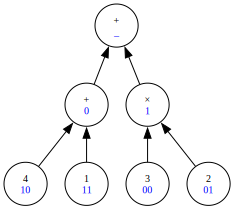

In [3]:
# NB: it may be necessary to restart the notebook and run this code cell again in order for the labeling below to match our written example.
from gkr.utils.display import print_header
from gkr.ac import ArithmeticCircuit

eg_count = 1

expression_01 = '(3*2) + (4 + 1)'
gkr_01 = ArithmeticCircuit(expression_01, prime=2**(31) - 1)

print_header(f"Example {eg_count}\n", level = 2)
display(gkr_01.graphviz_circuit_bitstring)

In [4]:
print_header(f"Example {eg_count}\n", level = 2)
gkr_01.print_gate_values()


EXAMPLE 1

GATE VALUES
LAYER 2

W_2(0,0) = 3
W_2(0,1) = 2
W_2(1,0) = 4
W_2(1,1) = 1

LAYER 1

W_1(0) = 5
W_1(1) = 6

LAYER 0

W_0() = 11



In [5]:
print_header(f"Example {eg_count}\n", level = 2)
gkr_01.print_tilde_W()


EXAMPLE 1

MULTLINEAR EXTENSIONS OF GATE-VALUE FUNCTIONS
LAYER 2

W̃_2(x_0, x_1) = 2147483645*x_0*x_1 + x_0 + 2147483646*x_1 + 3

LAYER 1

W̃_1(x_0) = x_0 + 5

LAYER 0

W̃_0() = 11



In [6]:
print_header(f"Example {eg_count}\n", level = 2)
gkr_01.print_wiring_predicates()


EXAMPLE 1

ADDITION WIRING PREDICATES (NONZERO VALUES)
LAYER 1

add_1((0),(1,0),(1,1)) = 1

LAYER 0

add_0((),(0),(1)) = 1


MULTIPLICATION WIRING PREDICATES (NONZERO VALUES)
LAYER 1

mult_1((1),(0,0),(0,1)) = 1
LAYER 0




In [7]:
print_header(f"Example {eg_count}\n", level = 2)
gkr_01.print_wiring_predicate_mles()


EXAMPLE 1

MULTLINEAR EXTENSIONS OF WIRING PREDICATES: ADD
LAYER 1

add̃_1(z_0,x_0,x_1,y_0,y_1) = x_0*x_1*y_0*y_1*z_0 + 2147483646*x_0*x_1*y_0*y_1 + 2147483646*x_0*y_0*y_1*z_0 + x_0*y_0*y_1

LAYER 0

add̃_0(x_0,y_0) = 2147483646*x_0*y_0 + y_0


MULTLINEAR EXTENSIONS OF WIRING PREDICATES: MULT
LAYER 1

mult̃_1(z_0,x_0,x_1,y_0,y_1) = 2147483646*x_0*x_1*y_0*y_1*z_0 + x_0*x_1*y_1*z_0 + x_0*y_0*y_1*z_0 + 2147483646*x_0*y_1*z_0 + x_1*y_0*y_1*z_0 + 2147483646*x_1*y_1*z_0 + 2147483646*y_0*y_1*z_0 + y_1*z_0

LAYER 0

mult̃_0(x_0,y_0) = 0



In [8]:
print_header(f"Example {eg_count}\n", level = 2)
gkr_01.print_verification_propagation_equation()


EXAMPLE 1

VERIFICATION OF LAYER-WISE GATE-VALUE PROPAGATION EQUATION
LAYER 1

W_1(0) = 5, sum { add_1((0),x,y) [ W_2(x) + W_2(y) ] + mult_1((0),x,y) [ W_2(x) W_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 5 ✓
W_1(1) = 6, sum { add_1((1),x,y) [ W_2(x) + W_2(y) ] + mult_1((1),x,y) [ W_2(x) W_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 6 ✓

LAYER 0

W_0() = 11, sum { add_0((),x,y) [ W_1(x) + W_1(y) ] + mult_0((),x,y) [ W_1(x) W_1(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 11 ✓



In [9]:
print_header(f"Example {eg_count}\n", level = 2)
gkr_01.print_verification_propagation_equation(mle=True)


EXAMPLE 1

VERIFICATION OF THALER'S IDENTITY
LAYER 1

(There are 2147483647 z-values in the domain; checking all would be slow.
 We will select 1000 z-values uniformly at random, and display at most 100 of them.)

W̃_1(606531572) = 606531577, sum { add̃_1((606531572),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1((606531572),x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 606531577 ✓
W̃_1(817512996) = 817513001, sum { add̃_1((817512996),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1((817512996),x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 817513001 ✓
W̃_1(1248026338) = 1248026343, sum { add̃_1((1248026338),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1((1248026338),x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 1248026343 ✓
W̃_1(2014996384) = 2014996389, sum { add̃_1((2014996384),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1((2014996384),x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 2014996389 ✓
W̃_1(411690077) = 411690082, sum { add̃_1((411690077),x,y) [ W̃_2(x) + W̃_2

<a id='formal_description'></a>
## The GKR protocol (formal description)
↑↑ [Contents](#contents) ↑ [Worked Example](#worked_example) ↓ [...](#...)

**Setup.** Let $C$ be a constant-input, strictly layered arithmetic circuit of depth $d$ with fan-in two.  
For each layer $i \in \{0,\ldots,d\}$, let $s_i$ denote the bit-length of gate labels at Layer $i$, and let
\begin{equation*}
W_i : \{0,1\}^{s_i} \to \mathbb{F},
\qquad
\widetilde{W}_i : \mathbb{F}^{s_i} \to \mathbb{F}
\end{equation*}
be the gate-value function and its multilinear extension.  

For each $i \in \{0,\ldots,d-1\}$, the circuit wiring is public and encoded by multilinear extensions
\begin{equation*}
\widetilde{\mathrm{add}}_i,\;\widetilde{\mathrm{mult}}_i :
\mathbb{F}^{s_i} \times \mathbb{F}^{s_{i+1}} \times \mathbb{F}^{s_{i+1}} \to \mathbb{F}.
\end{equation*}

**Layer 0 (output layer).**

- P sends a polynomial function
  \begin{equation*}
  \widetilde{W}_0^* : \mathbb{F}^{s_0} \to \mathbb{F},
  \end{equation*}
  claimed to be the multilinear extension of the output gate-value function.

- V samples
  \begin{equation*}
  \rho_0 \leftarrow \mathbb{F}^{s_0}
  \end{equation*}
  uniformly at random, and evaluates the claimed polynomial at that point.

- Let
  \begin{equation*}
  \alpha_0 := \widetilde{W}_0^*(\rho_0) \in \mathbb{F}.
  \end{equation*}

In an honest execution, $\widetilde{W}_0^* \overset{?}{=}\widetilde{W}_0$, and hence $\alpha_0\overset{?}{=}\widetilde{W}_0(\rho_0)$. The remainder of the protocol is devoted to justifying this value. (We place a question mark over an equality symbol to remind the reader that these equalities may not hold if P is dishonest.)

**Layer i, $0 \le i \le d-1$.** At the start of Layer i, V holds:
- a point $\rho_i \in \mathbb{F}^{s_i}$,
- a scalar $\alpha_i \in \mathbb{F}$,

which, in an honest execution, satisfy $\alpha_i\overset{?}{=}\widetilde{W}_i(\rho_i)$. Define the polynomial function
\begin{equation*}
g(\mathbf{x},\mathbf{y})
:=
\widetilde{\mathrm{add}}_i(\rho_i,\mathbf{x},\mathbf{y})
\big[\widetilde{W}_{i+1}(\mathbf{x})+\widetilde{W}_{i+1}(\mathbf{y})\big]
+
\widetilde{\mathrm{mult}}_i(\rho_i,\mathbf{x},\mathbf{y})
\big[\widetilde{W}_{i+1}(\mathbf{x})\widetilde{W}_{i+1}(\mathbf{y})\big],
\end{equation*}
a polynomial on $\mathbb{F}^{s_{i+1}} \times \mathbb{F}^{s_{i+1}}$. If P is honest, then by Thaler's identity,
\begin{equation*}
\alpha_i
\overset{?}{=}
\sum_{(\mathbf{x},\mathbf{y}) \in \{0,1\}^{s_{i+1}} \times \{0,1\}^{s_{i+1}}}
g(\mathbf{x},\mathbf{y}),
\end{equation*}
and this equality must hold in order for the protocol to continue without rejection.

**Sum-check at Layer i.**

- P and V run the sum-check protocol on the above sum.
- Let $m := 2s_{i+1}$ be the number of Boolean variables.
- V introduces random challenges
  \begin{equation*}
  r_0,\ldots,r_{m-1} \in \mathbb{F},
  \end{equation*}
  grouped as
  \begin{equation*}
  r_x := (r_0,\ldots,r_{s_{i+1}-1}),
  \qquad
  r_y := (r_{s_{i+1}},\ldots,r_{m-1}).
  \end{equation*}

- P sends round polynomials $g_0^*,\ldots,g_{m-1}^*$.
- V checks degree bounds and round-to-round consistency, with the initial consistency condition
  \begin{equation*}
  \alpha_i \overset{?}{=} g_0^*(0)+g_0^*(1).
  \end{equation*}
- In particular, V checks that each round polynomial satisfies
  \begin{equation*}
  \deg g_j^* \overset{?}{\le} 4s_{i+1},
  \end{equation*}
  which is a valid upper bound on the degree of the true round polynomials induced by $g$.

At the end of sum-check, correctness reduces to
\begin{equation*}
g_{m-1}^*(r_{m-1}) \overset{?}{=} g(r_x,r_y).
\end{equation*}

**Bridging and folding.** V cannot evaluate $g(r_x,r_y)$ directly, since it depends on $\widetilde{W}_{i+1}$. P therefore supplies two field elements
\begin{equation*}
z_x^*, \, z_y^* \in \mathbb{F},
\end{equation*}
intended (in an honest execution) to equal
\begin{equation*}
\widetilde{W}_{i+1}(r_x), \, \widetilde{W}_{i+1}(r_y).
\end{equation*}

Using only public data, V checks
\begin{equation*}
g_{m-1}^*(r_{m-1}) \overset{?}{=} \widetilde{\mathrm{add}}_i(\rho_i,r_x,r_y)\big[z_x^*+z_y^*\big]
+
\widetilde{\mathrm{mult}}_i(\rho_i,r_x,r_y)\big[z_x^*z_y^*\big].
\end{equation*}
(V computes both sides themself.) If this check fails, V rejects.

Assuming it passes, define the affine line
\begin{equation*}
\ell : \mathbb{F} \to \mathbb{F}^{s_{i + 1}}, \quad \ell_{i+1}(t) := (1-t)r_x + t r_y,
\end{equation*}
and the associated ground-truth univariate polynomial function
\begin{equation*}
q_{i + 1} : \mathbb{F} \to \mathbb{F}, \quad q_{i+1}(t) := \widetilde{W}_{i+1}(\ell_{i+1}(t)).
\end{equation*}

P sends a univariate polynomial $q_{i+1}^*$, purported to equal $q_{i+1}$. V checks:
1. $\deg q_{i+1}^* \overset{?}{\le} s_{i+1}$,
2. $q_{i+1}^*(0) \overset{?}{=} z_x^*$ and $q_{i+1}^*(1) \overset{?}{=} z_y^*$.

If these checks pass, V samples
\begin{equation*}
\tau_{i+1} \leftarrow \mathbb{F}
\end{equation*}
uniformly at random, and sets
\begin{equation*}
\rho_{i+1} := \ell_{i+1}(\tau_{i+1}),
\qquad
\alpha_{i+1} := q_{i+1}^*(\tau_{i+1}).
\end{equation*}

In an honest execution, $\alpha_{i+1}\overset{?}{=}\widetilde{W}_{i+1}(\rho_{i+1})$. The protocol then proceeds to Layer i + 1.

**Final layer.** At Layer d - 1, the same procedure is followed. However, the child layer $d$ consists of input gates, so $\widetilde{W}_d$ is fully determined by the public inputs. V can therefore evaluate $\widetilde{W}_d$ directly at the final challenge point and perform the last consistency check explicitly. If it passes, V accepts; otherwise, V rejects.

<a id='references'></a>
## References
↑↑ [Contents](#contents) ↑ [...](#...)

<a id='cmt2012'></a>
[CMT2012] Cormode, G., M. Mitzenmacher, and J. Thaler. '[Practical verified computation with streaming interactive proofs](https://doi.org/10.1145/2090236.2090245).' In _Proceedings of the 3rd Innovations in Theoretical Computer Science Conference_, 90&ndash;112, 2012.

<a id='gkr2008'></a>
[GKR2008] Goldwasser, S., Y. T. Kalai, and G. N. Rothblum. '[Delegating computation: interactive proofs for muggles](https://doi.org/10.1145/2699436).' _Journal of the ACM_, 62(4):1&ndash;64, 2008.

<a id='tha2015'></a>
[THA2015] Thaler, J. '[A note on the GKR protocol](https://api.semanticscholar.org/CorpusID:16402332).' 2015.

<a id='tha2022'></a>
[THA2022] Thaler, J. [_Proofs, Arguments, and Zero-Knowledge_](https://people.cs.georgetown.edu/jthaler/ProofsArgsAndZK.pdf). Foundations and Trends in Privacy and Security, Now Publishers, 2022.